## **Fast AI Experements Based on [this](https://towardsdatascience.com/transfer-learning-using-the-fastai-library-d686b238213e) blog**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# !unzip drive/My\ Drive/ammi-2020-convnets.zip 
# !mkdir models
# !cp -r drive/My\ Drive/data/models/* models/.


In [6]:
!pip install pretrainedmodels
!pip uninstall torch torchvision -y 
!pip install torch==1.4.0 torchvision==0.5.0 

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=92828ea325c40589cda969ee81bd37a937a0b13d761cc2b39d7d2a13806933c9
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
Uninstalling torch-1.5.0+cu101:
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 10kB/s 


# Importing Fast AI library

In [0]:
import os 
import pretrainedmodels

from tqdm import tqdm

In [8]:
from fastai import *
from fastai.vision import *

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

from math import floor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Looking at the data

In [0]:
train_path = "./train/train"
test_path = "./test/test/0"

In [0]:
def get_labels(file_path): 
    dir_name = os.path.dirname(file_path)
    split_dir_name = dir_name.split("/")
    dir_levels = len(split_dir_name)
    label  = split_dir_name[dir_levels - 1]
    return(label)

In [11]:
get_labels("./train/train/cgm/train-cgm-528.jpg")

'cgm'

In [12]:
from glob import glob
imagePatches = glob("./train/train/*/*.*", recursive=True)
imagePatches[0:10]

['./train/train/healthy/train-healthy-103.jpg',
 './train/train/healthy/train-healthy-280.jpg',
 './train/train/healthy/train-healthy-191.jpg',
 './train/train/healthy/train-healthy-161.jpg',
 './train/train/healthy/train-healthy-243.jpg',
 './train/train/healthy/train-healthy-313.jpg',
 './train/train/healthy/train-healthy-218.jpg',
 './train/train/healthy/train-healthy-203.jpg',
 './train/train/healthy/train-healthy-17.jpg',
 './train/train/healthy/train-healthy-166.jpg']

In [0]:
path=""

transform_kwargs = {"do_flip": True,
                    "flip_vert": True,
                    "max_rotate": 180,
                    "max_zoom": 1.1,
                    "max_lighting": 0.2,
                    "max_warp": 0.2,
                    "p_affine": 0.75,
                    "p_lighting": 0.7}

tfms = get_transforms(**transform_kwargs)


In [0]:
data = ImageDataBunch.from_name_func(path, imagePatches, label_func=get_labels,  size=256, 
                                     bs=32,num_workers=2,test = test_path,ds_tfms=tfms
                                  ).normalize(imagenet_stats)

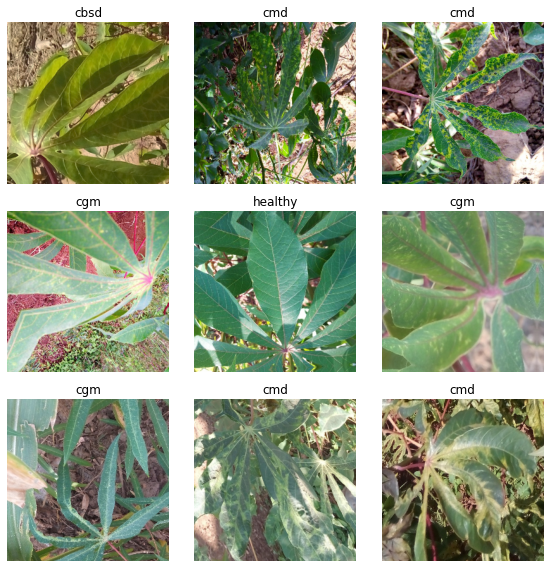

In [15]:
data.show_batch(rows=3, figsize=(8,8))

In [16]:
print(data.classes)
len(data.classes),data.c

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


(5, 5)

# AUC / ROC 

Define AUC_ROC metric callback

In [0]:
class RegMetrics(Callback):
  "Stores predictions and targets to perform calculations on epoch end."
  def on_epoch_begin(self, **kwargs):
    self.targs, self.preds = Tensor([]), Tensor([])

  def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
    assert last_output[:, 1].numel() == last_target.numel(), "Expected same numbers of elements in pred {} & targ {}".format(last_output.shape, last_target.shape)
    self.preds = torch.cat((self.preds, partial(F.softmax, dim=-1)(last_output)[:, 1].cpu()))
    self.targs = torch.cat((self.targs, last_target.cpu().float()))

# Define some custom metrics 
class AUCROC(RegMetrics):
  """ Compute the area under the receiver operating characteristic curve. """
  def on_epoch_begin(self, **kwargs):
    super().on_epoch_begin()
    
  def on_epoch_end(self, **kwargs):
    self.metric = roc_auc_score(self.targs, self.preds)

# Transfer learning using a pre-trained model: ResNet 50

In [20]:
## To create a ResNET 50 with pretrained weights
learn = create_cnn(data,models.densenet121, metrics=[error_rate,accuracy])
learn.load('densenet121_86.pt')
# learn = create_cnn(data,models.vgg19_bn, metrics=[error_rate,accuracy])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Learner(data=ImageDataBunch;

Train: LabelList (4525 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy,healthy,healthy,healthy,healthy
Path: .;

Valid: LabelList (1131 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
cbsd,cmd,cmd,healthy,cmd
Path: .;

Test: LabelList (3774 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ., model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _De

In [21]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.354214,0.110715,0.030062,0.969938,01:04


KeyboardInterrupt: ignored

In [0]:
learn.save('vgg_86.pt')

# Result Exploration

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, figsize=(20,25))

# Confusion Matrix

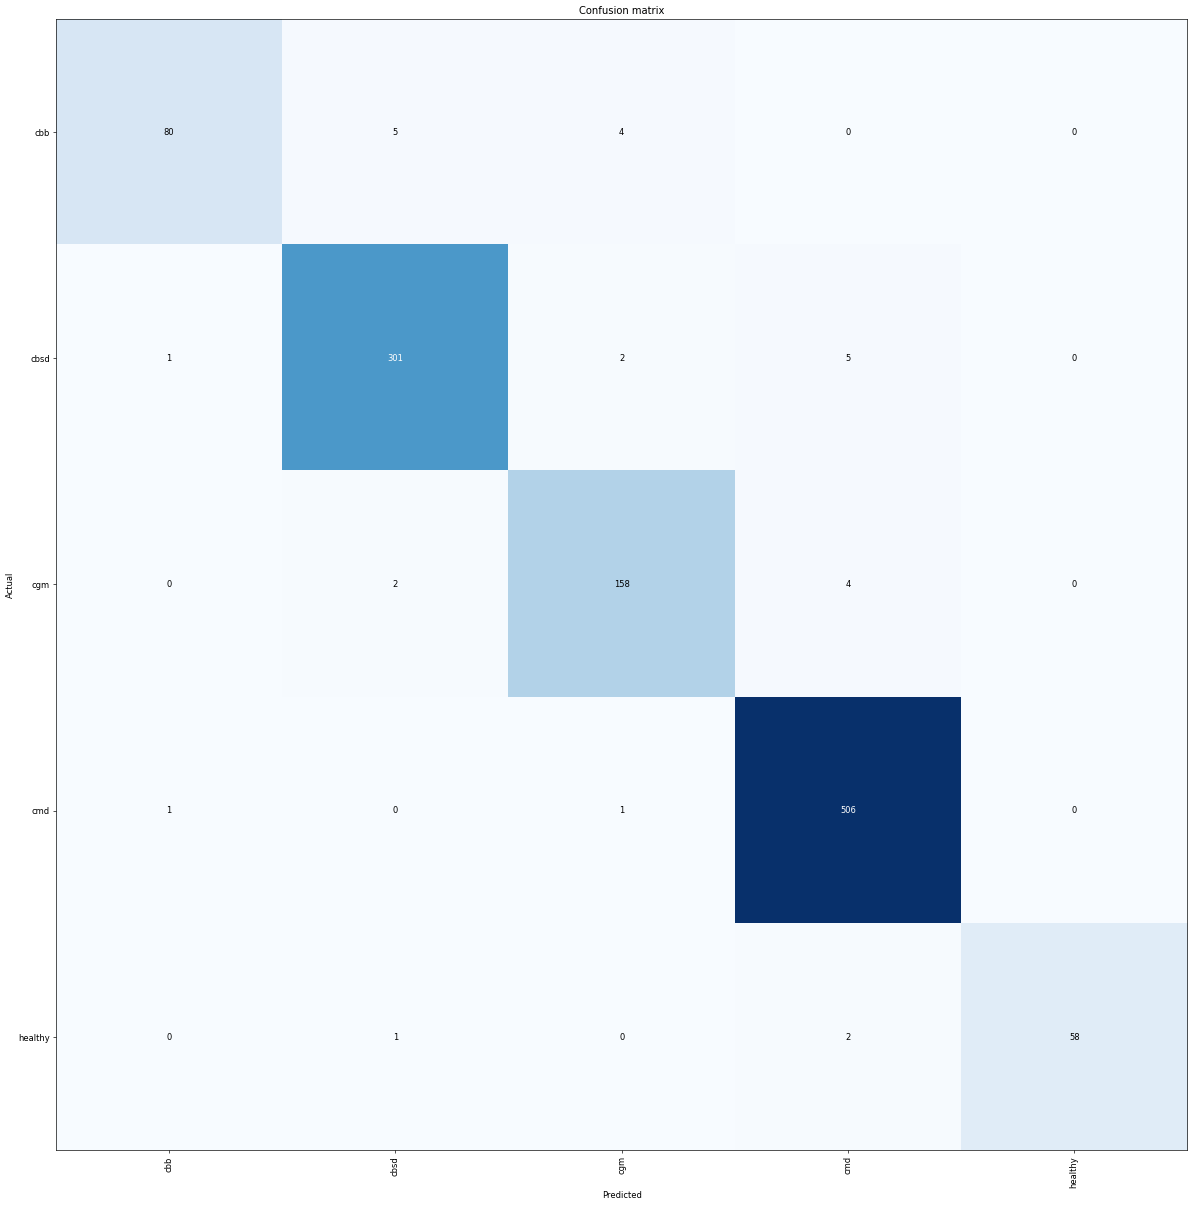

In [0]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

# LR Finder

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


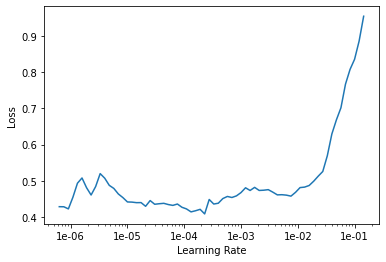

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.652920,0.912612,0.248453,0.751547,01:02
1,0.620391,0.478725,0.143236,0.856764,01:02
2,0.531150,0.413674,0.128205,0.871795,01:02
3,0.444224,0.365663,0.109637,0.890363,01:02
4,0.361994,0.343160,0.104332,0.895668,01:02


In [0]:
learn.save('densenet121_89.pt')

# Submission

# Model Ensambling

In [22]:
densenet_learn = create_cnn(data,models.densenet121, metrics=[error_rate,accuracy])
densenet_learn.load('densenet121_86.pt')
densenet_learn.fit_one_cycle(5)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.426414,0.111437,0.027409,0.972591,01:02
1,0.368764,0.127681,0.034483,0.965517,01:02
2,0.324171,0.156053,0.050398,0.949602,01:03
3,0.304098,0.134794,0.038019,0.961981,01:03
4,0.283615,0.136264,0.037135,0.962865,01:03


resnet 50

In [26]:
resnet_learn = create_cnn(data,models.resnet50, metrics=[error_rate,accuracy])
resnet_learn.load('resnet_50_82.pt')
resnet_learn.fit_one_cycle(5,max_lr=slice(1e-6,1e-5))

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.576670,0.352131,0.120248,0.879752,01:03
1,0.576812,0.352272,0.119363,0.880637,01:03
2,0.598704,0.350891,0.114943,0.885057,01:03
3,0.559902,0.352738,0.121132,0.878868,01:03
4,0.601774,0.355670,0.122016,0.877984,01:03


In [0]:
resnet_learn.save('resnet50_87.pt')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


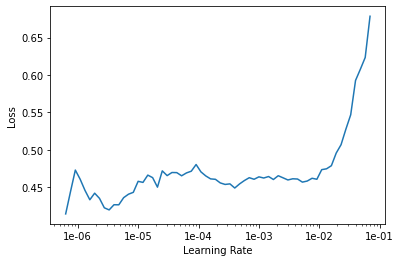

In [25]:
resnet_learn.lr_find()
resnet_learn.recorder.plot()

VGG 19

In [31]:
vgg_learn = create_cnn(data,models.vgg19_bn, metrics=[error_rate,accuracy])
vgg_learn.load('vgg_92.pt')
vgg_learn.fit_one_cycle(5,max_lr=slice(1e-6,1e-5))

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.385591,0.209987,0.069850,0.930150,01:05
1,0.358149,0.207089,0.068966,0.931035,01:04
2,0.401393,0.206473,0.069850,0.930150,01:04
3,0.369776,0.203507,0.061008,0.938992,01:04
4,0.382594,0.208662,0.068966,0.931035,01:05


In [0]:
vgg_learn.save('vgg_93.pt')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


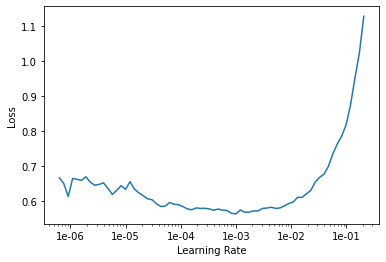

In [30]:
resnet_learn.lr_find()
resnet_learn.recorder.plot()

# Ensamble Predict

In [0]:
result_csv = 'sample_submission_file.csv'
test_path = './test/test/0/'
class_names = data.classes

In [0]:
def ensemble_predition(test_img):
    img = open_image(test_path + test_img)
    
    resnet50_predicition = resnet_learn.predict(img)
    densenet121_predicition = densenet_learn.predict(img)
    vgg_predicition = vgg_learn.predict(img)
    
    #ensemble average
    sum_pred = resnet50_predicition[2] + densenet121_predicition[2] + vgg_predicition[2]
    prediction = sum_pred / 3
    
    #prediction results
    predicted_label = torch.argmax(prediction).item()
    
    return predicted_label

In [59]:
#to give np array the correct style
submission_data = np.empty([1,2])

#progress bar
with tqdm(total=len(os.listdir(test_path))) as pbar:       
    #test all test images
    for img in os.listdir(test_path):
        label = ensemble_predition(img)
        new_np_array = np.array([[class_names[label],img]])
        submission_data = np.concatenate((submission_data, new_np_array), axis=0)
        pbar.update(1)

100%|██████████| 3774/3774 [03:51<00:00, 16.32it/s]


In [0]:
#save final submission
result_df = pd.DataFrame(submission_data, columns=['Category','id'])
result_df.to_csv(result_csv, index=False)
